##Source data
When you import data into Neo4j, you typically start with a set of source files.

You may have exported this source data from:

1. Relational databases

2. Web APIs

3. Public data directories

4. BI tools

5. Speadsheets (e.g. Excel or Google Sheets)

##Export to CSV

Most data systems will have an option for exporting data to CSV files as it is a common format for data exchange.

##Create a graph
Before you start the import process, you should:

1. Understand the data in the source CSV files.

2. Inspect and clean (if necessary) the data in the source data files.

3. Understand the graph data model you will be implementing during the import.

Before you import data into Neo4j, there is no data structure, **only the database itself** - as you import data, **you create the graph data model.**

Once you have the source data and a graph data model, you can create the graph by importing the data.

###The import involves creating Cypher code to:

1. Read the source data.

2. Transform the data as needed.

3. Create nodes, relationships, and properties to create the graph.

##CSV files
CSV files store data in a structure where a special character, usually a comma, separates each value in a row, and each record is a new row in the file.

In [ ]:
personId,name,birthYear
23945,Gerard Pires,1942
553509,Helen Reddy,1941
113934,Susan Flannery,1939

##Field Terminator
In the example above, a comma (,) separates each field, but other characters can be used, such as a tab (\t) or a pipe (|).

This is the same data as above but separated by a pipe character:

In [ ]:
personId|name|birthYear
23945|Gerard Pires|1942
553509|Helen Reddy|1941
113934|Susan Flannery|1939

##Headers
Typically, the first row in a CSV file is a header row, which contains the names of the columns.

In [ ]:
personId|name|birthYear

Headers are not mandatory; when working with CSV files with no header row, you will need to know the order of the columns and refer to them by index.

##Normalized data
If the source data is normalized (e.g. when exported from a relational data model) there will typically be multiple CSV files.

**Each CSV file will represent a table in the relational data model, and the files will be related to each other by unique IDs.**

##De-normalized data
If the source data is de-normalized, there will typically be a single CSV file. The single file will contain all the data, often duplicated where there are relationships between entities.

###De-normalized data typically represents data from multiple tables.

##**NOTE** The CSV file format is flexible. The field terminator can be a comma, tab, pipe, or any other character. Headers are optional. CSV files can represent normalized and de-normalized data.

In [ ]:
#load csv and counts row

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/people.csv'
as row
RETURN count(row)

In [ ]:
#correct syntax

LOAD CSV WITH HEADERS FROM 'file:///data.csv' AS line
RETURN line

#Construct and run the LOAD CSV statement
The structure of your LOAD CSV statement should take into account the following:

1. The location of your CSV file.

2. The field terminator.

3. Whether the file contains headers.

In [ ]:
LOAD CSV [WITH HEADERS] FROM url [AS alias] [FIELDTERMINATOR char]
RETURN alias

#**Create Person nodes**

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = row.born,
p.died = row.died

In [ ]:
MATCH (p:Person) RETURN p LIMIT 25

In [ ]:
#Example

LOAD CSV WITH HEADERS 'file:///games.csv' AS record
MERGE (g:Game {title: record.title})

##**Unique IDs and Constraints**
A Neo4j best practice is to use an **ID as a unique property value for each node.**

Unique IDs help **ensure duplicate data is not created.** When you load data from CSV files, you rely heavily upon the IDs specified in the file. **If the IDs in your CSV file are not unique for the same entity (node), you could create duplicate data.** You may also have problems loading the data and creating relationships between nodes.

You can **add constraints** to your database to stop the creation of nodes with duplicate IDs.

In [ ]:
CREATE CONSTRAINT [constraint_name] [IF NOT EXISTS]
FOR (n:LabelName)
REQUIRE n.propertyName IS UNIQUE

In [ ]:
CREATE CONSTRAINT Person_tmdbId IF NOT EXISTS
FOR (x:Person)
REQUIRE x.tmdbId IS UNIQUE

In [ ]:
SHOW CONSTRAINTS

If you try to create a Person node with a duplicate tmdbId property value, Neo4j will raise an error.



In [ ]:
CREATE (p:Person {tmdbId: 3}) RETURN p

#Node(0) already exists with label `Person` and property `tmdbId` = 3

In [ ]:
#Drop a constraint
DROP CONSTRAINT [constraint_name]

##Adding Movie Nodes


In [ ]:
CREATE CONSTRAINT Movie_movieId
FOR (x:Movie)
REQUIRE x.movieId IS UNIQUE

In [ ]:
#Load the Movie nodes
LOAD CSV WITH HEADERS FROM 'https://data.neo4j.com/importing-cypher/movies.csv' AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = row.imdbId,
m.released = row.released,
m.title = row.title,
m.year = row.year,
m.plot = row.plot,
m.budget = row.budget

You should construct a Cypher to:

1. Load the movies.csv CSV file from **https://data.neo4j.com/importing-cypher/movies.csv**

2. Create the **Movie nodes** using **MERGE** with the **movieId** field as the **unique identifier.**

3. Set the following **properties on the Movie nodes:**

tmdbId

imdbId

released

title

year

plot

budget

In [ ]:
MATCH (m:Movie) RETURN m LIMIT 25

#**Relationships**

Create **ACTED_IN relationships** between the **Person and Movie nodes.**

##Creating relationships
The acted_in.csv file contains the following data:

1. movieId - the movieId property of the Movie node

2. person_tmdbId - the tmbdId property of the Person node

3. role - the role the person played in the movie

###To create the ACTED_IN relationship, you will need to:

1. LOAD CSV data from the acted_in.csv file.

2. MATCH the relevant Person and Movie nodes.

3. Use MERGE to create the ACTED_IN relationship between the matched Person and Movie nodes.

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/acted_in.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:ACTED_IN]->(m)
SET r.role = row.role

Try to identify:

1. The 2 MATCH clauses that find the appropriate Person and Movie nodes using the movieId and person_tmdbId properties.

2. The MERGE clause that creates the ACTED_IN relationship between the matched p and m nodes

3. The SET clause that sets the role property of the ACTED_IN relationship r.

In [ ]:
MATCH (p:Person)-[r:ACTED_IN]->(m:Movie) RETURN p, r, m LIMIT 25

#**DIRECTED relationship**
you will need to create the **DIRECTED relationships between the Person and Movie nodes.**

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/directed.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:DIRECTED]->(m)

In [ ]:
#To verify that you created the DIRECTED relationship successfully

MATCH (p:Person)-[r:DIRECTED]->(m:Movie) RETURN p, r, m LIMIT 25

In [ ]:
#Once you have created the ACTED_IN and DIRECTED relationships, you can use the data to find people who directed and acted in the same movie.

MATCH (p:Person)-[:ACTED_IN]->(m:Movie)<-[:DIRECTED]-(p:Person)
RETURN p, m

#**Example:**
airports.csv



In [ ]:
airport_code|name|city|country
SFO|San Francisco International Airport|San Francisco|United States
NYC|John F. Kennedy International Airport|New York City|United States
LHR|London Heathrow Airport|London|United Kingdom

flights.csv



In [ ]:
flight_number,airline,departure_airport,arrival_airport
SF_4863,Swift Flights,SFO,NYC
SF_4864,Swift Flights,NYC,SFO
AA_9135,America Airways,SFO,LHR
AA_9136,America Airways,LHR,SFO
BA_2945,Britain Atlantic,LHR,NYC
BA_2946,Britain Atlantic,NYC,LHR

1. Load the CSV file
Select the correct Cypher statement to load the data from the airports.csv file.




In [ ]:
LOAD CSV WITH HEADERS FROM 'file:///airports.csv' AS row FIELDTERMINATOR '|'
MERGE (a:Airport {airport_code: row.airport_code))
SET a.name = row.name, a.city = row.city, a.country = row.country


2. Creating relationship properties
The flights.csv data file contains information about flights between airports. The following Cypher statement will create FLIGHT relationships between Airport nodes based on the data in the flights.csv file.

Select the correct Cypher statement to add the airline property to the relationship.



In [ ]:
LOAD CSV WITH HEADERS 'file:///flights.csv' AS row
MATCH (d:Airport {airport_code: row.departure_airport})
MATCH (a:Airport {airport_code: row.arrival_airport})
MERGE (d)-[f:FLIGHT {flight_number: row.flight_number}]->(a)
SET f.airline = row.airline

3. Creating relationship properties
The airport_code property is unique. Select the correct Cypher statement to create the constraint.



In [ ]:
CREATE CONSTRAINT Airport_code
FOR (x:Airport)
REQUIRE x.airport_code IS UNIQUE


4. Why have a Unique property?
Select why having a unique property value for each node is a Neo4j best practice:

  **Help ensure duplicate data is not created**
  
  **Avoid potential problems when creating relationships between nodes**


#**Nodes**

###Load the CSV file
You will load a CSV file of "person" data into Person nodes in Neo4j. The CSV file contains the following fields:

person_tmdbId

bio

born

bornIn

died

person_imdb

Id

name

person_poster

person_url

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = row.born,
p.died = row.died

###Try to answer the following questions:

1. Where does the CSV data come from?

2. What does the MERGE clause do?

3. What variable holds the data from the CSV file?

4. Where are the properties set?

5. Why is the toInteger function used?

###Review the answers
1. The LOAD CSV clause loads the CSV file from the specified URL.

2. The MERGE clause creates a new Person if one does not already exist with the same tmdbId value.

3. The row variable holds the data from the CSV file.

4. The SET clause sets the properties of the Person node to the values of the corresponding fields in the CSV file.

5. The toInteger function converts the person_tmdbId and person_imdbId values from strings to integers.

In [ ]:
MATCH (p:Person) RETURN p LIMIT 25

##**Unique IDs and Constraints**
A Neo4j best practice is to use an **ID as a unique property value for each node.**

Unique IDs help ensure **duplicate data is not created.** When you load data from CSV files, you rely heavily upon the IDs specified in the file. If the IDs in your CSV file are not unique for the same entity (node), you could create duplicate data. You may also have problems loading the data and creating relationships between nodes.

You can **add constraints to your database to stop the creation of nodes with duplicate IDs.**

In [ ]:
#Create a unique constraint

CREATE CONSTRAINT [constraint_name] [IF NOT EXISTS]
FOR (n:LabelName)
REQUIRE n.propertyName IS UNIQUE

The constraint is for **a property on all nodes with a specified label.**

The constraint_name is **optional,** but it is good practice to specify one. If you do not specify a constraint name, Neo4j will create one for you.

The **IF NOT EXISTS** clause is also **optional -** if not used Neo4j will generate an error **if the constraint already exists.**

In [ ]:
#Person node constraint
CREATE CONSTRAINT Person_tmdbId IF NOT EXISTS
FOR (x:Person)
REQUIRE x.tmdbId IS UNIQUE

In [ ]:
CREATE CONSTRAINT Person_tmdbId
FOR (x:Person)
REQUIRE x.tmdbId IS UNIQUE

In [ ]:
SHOW CONSTRAINTS

In [ ]:
#If you try to create a Person node with a duplicate tmdbId property value, Neo4j will raise an error.

CREATE (p:Person {tmdbId: 3}) RETURN p


Node(0) already exists with label `Person` and property `tmdbId` = 3

In [ ]:
#Drop a constraint

DROP CONSTRAINT [constraint_name]

#**Data Types**

###**Casting**
All data loaded using LOAD CSV will be **returned as strings -** you need to **cast the data to an appropriate data type** before being written to a property.

###The types of data that you can store as properties in Neo4j include:

  String

  Integer

  Float (decimal values)

  Boolean

  Date/Datetime

  Point (spatial)

  Lists of values

There are Cypher functions to cast data to appropriate types. For example, when creating the Person nodes, you used the toInteger() function to cast IDs to integers.


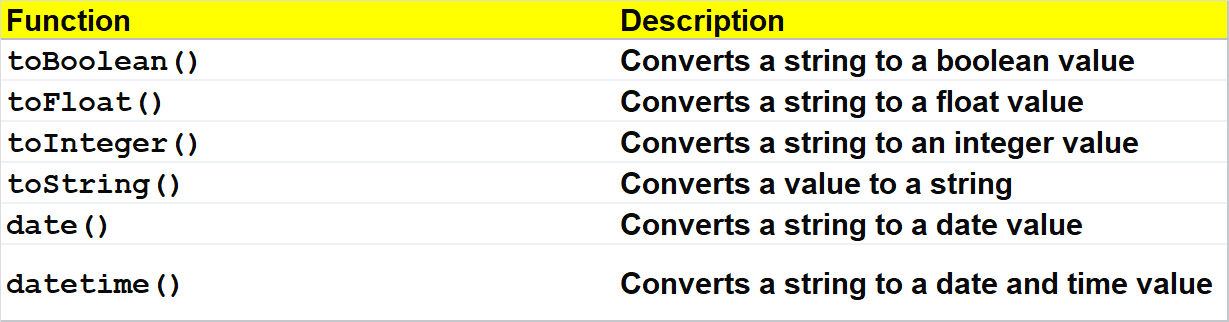

You can use the apoc.meta.nodeTypeProperties() function to show the data types used in the graph:

In [ ]:
CALL apoc.meta.nodeTypeProperties()
YIELD nodeType, propertyName, propertyTypes

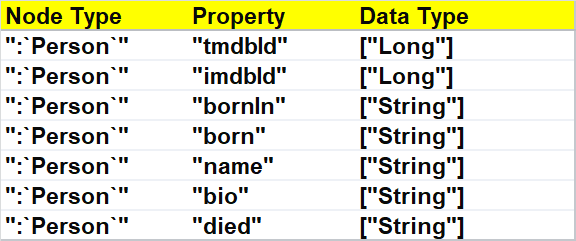

Neo4j will return the data type **Long** for integer values.

##**Person node dates**
The Person nodes born and died properties are both dates, **not strings.**

You used this Cypher statement to create the Person nodes:

In [ ]:
LOAD CSV WITH HEADERS FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = row.born,
p.died = row.died

In [ ]:
#Corrected person nodes.

LOAD CSV WITH HEADERS FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = date(row.born),
p.died = date(row.died)

##**Using MERGE not CREATE?**

As **MERGE** was used in this Cypher statement, you can **run it multiple times without creating duplicate nodes.** It will **update** the existing nodes with the new date values. If you used **CREATE** instead, you would **create new nodes each time** you ran the statement.

Use the **apoc.meta.nodeTypeProperties function** again to check that the born and died properties are now Date values:

In [ ]:
CALL apoc.meta.nodeTypeProperties()
YIELD nodeType, propertyName, propertyTypes

###Advantages of using **Date**

The **Date data type** allows you to extract the **year, month, and day** from the **date.** For example,

In [ ]:
MATCH (p:Person)
RETURN p.born.year as YearOfBirth

##**Adding Properties**

you will **update the import to add new properties to the Movie nodes** and cast them to the correct type.

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv'
AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = row.released,
m.title = row.title,
m.year = row.year,
m.plot = row.plot,
m.budget = row.budget

The year and budget properties are **not cast** and therefore **stored as strings.**

Update and run the existing import to cast the year and budget properties to integers using the **toInteger() function.**

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv'
AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = row.released,
m.title = row.title,
m.year = toInteger(row.year),
m.plot = row.plot,
m.budget = toInteger(row.budget)

###The movies.csv file also contains the following additional properties:

  imdbRating

  poster

  runtime

  imdbVotes

  revenue

  url

Review the data in the file and identify the data type and cast function for each property.

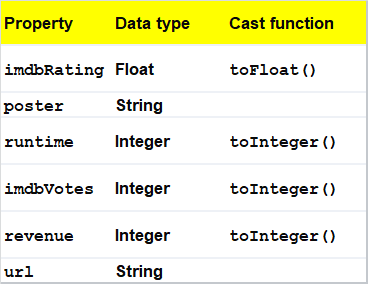

Finally, update the import to add these properties to the Movie nodes and cast them to the correct type.

##**Lists**

1. Multi-value properties and lists

2. How to transform a string value into a list

3. The split function


##What is a Multi-value property?
A multi-value property is a property that can **hold one or more values.** Neo4j represents this type of **data as a list (or "StringArray").**

All values in a list must have the same data type. For example:

**["Apple", "Banana, "Orange"]**

**[100, 55, 4]**

The movies.csv data file contains multi-value properties, including:

1. countries - the countries which produced the movie

2. languages - the languages spoken in the movie

Find the countries and languages data in the movies.csv file. You will see that each property contains a list of values separated by a | character. For example:

In [ ]:
USA|France|Italy|Germany
English|Mandarin|Russian

##**Split the data into a list**
The split function will **transform a string value into a list.** The split function takes two arguments:

1. The string to split

2. The character to split on

This updated Movie import creates a list of countries by using the split function:

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv'
AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = date(row.released),
m.title = row.title,
m.year = toInteger(row.year),
m.plot = row.plot,
m.budget = toInteger(row.budget),
m.imdbRating = toFloat(row.imdbRating),
m.poster = row.poster,
m.runtime = toInteger(row.runtime),
m.imdbVotes = toInteger(row.imdbVotes),
m.revenue = toInteger(row.revenue),
m.url = row.url,
m.countries = split(row.countries, '|')

The statement sets the countries property as a list by **splitting the data from the CSV file by the | character.**

Run the query and inspect the countries property data by writing a **MATCH query to return the data.**

You can query data in a list using the **IN operator.** For example, finding all the movies where "French" is a listed language.

In [ ]:
MATCH (m:Movie)
WHERE "France" IN m.countries
RETURN m

##Example

###List types?
True or False - values in **a list can be of different data types.**

###False

###Hint

This list would **not be valid.**

**[100, "Banana", 4.1]**

##**Add the languages property**

Your challenge is to modify this Cypher query to **add the languages property.**



In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv' AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = date(row.released),
m.title = row.title,
m.year = toInteger(row.year),
m.plot = row.plot,
m.budget = toInteger(row.budget),
m.imdbRating = toFloat(row.imdbRating),
m.poster = row.poster,
m.runtime = toInteger(row.runtime),
m.imdbVotes = toInteger(row.imdbVotes),
m.revenue = toInteger(row.revenue),
m.url = row.url,
m.countries = split(row.countries, '|'),
m.languages = split(row.languages, '|')

The languages property should be the **list of languages** in the CSV file. As with **countries each language is separated by the (|) character.**

##**LABELS**

you will learn how to **add additional labels to existing nodes.**

##Add Labels to Existing Nodes
Adding labels to existing nodes can make your graph more useful and performant.

The Person nodes in the graph represent both actors and directors. To determine if a person is an actor or director, you need to query the ACTED_IN or DIRECTED relationships. Alternatively, you could add labels to the existing nodes to distinguish between actors and directors.

You can add labels to a node using SET, the syntax is:

In [ ]:
MATCH (n)
SET n:Label

The following query would **add the Actor label to all Person nodes** that have acted in a movie:

In [ ]:
MATCH (p:Person)-[:ACTED_IN]->()
SET p:Actor

The query:

1. Finds **all the Person nodes with an ACTED_IN relationship to a node**

2. Sets the **Actor label to those nodes**

As there are people in the database who have acted in more than one movie, you can use **WITH DISTINCT** to ensure that each person is **only labeled once.** Although not essential, this will improve the performance of the statement.

In [ ]:
MATCH (p:Person)-[:ACTED_IN]->()
WITH DISTINCT p SET p:Actor

In [ ]:
#Add Actor label

MATCH (p:Person)-[:ACTED_IN]->()
WITH DISTINCT p SET p:Actor

In [ ]:
#You can confirm it was successful by using the Actor label to find actors in the graph:

MATCH (a:Actor) RETURN a LIMIT 25

##Filtering by labels is faster

By adding the **Actor label** to the graph, queries that use the **label rather than the relationship will be quicker to return.**

##note:   A node can have one or more labels.

##Add Director label
Your challenge is to create a Cypher statement that **adds the Director label to all Person nodes with a DIRECTED relationship to a Movie node.**

In [ ]:
MATCH (p:Person)-[:ACTED_IN]->()
WITH DISTINCT p SET p:Actor

#**TEST**

In [ ]:
id,title,author,publication_year,genre,rating,still_in_print,last_purchased
19515,The Heights,Anne Conrad,2012,Comedy,5,true,2023/4/12 8:17:00
39913,Starship Ghost,Michael Tyler,1985,Science Fiction|Horror,4.2,false,2022/01/16 17:15:56
60980,The Death Proxy,Tim Brown,2002,Horror,2.1,true,2023/11/26 8:34:26
18793,Chocolate Timeline,Mary R. Robb,1924,Romance,3.5,false,2022/9/17 14:23:45
67162,Stories of Three,Eleanor Link,2022,Romance|Comedy,2,true,2023/03/12 16:01:23
25987,Route Down Below,Tim Brown,2006,Horror,4.1,true,2023/09/24 15:34:18

1. What cast function?
What function would you use to cast the id field?

toInteger()

2. What data type?
What data type would you use for the last_purchased field?

DateTime

3. Setting additional labels
Complete the following Cypher statement to set an InPrint label to all nodes that have a still_in_print property value of true.



In [ ]:
MATCH (n)
WHERE n.still_in_print = true
SET n:InPrint

4. Multi-value property?
Which field in the data should be split into a multi-value property?

genre

#**Building an Import Process**

you have created queries which complete the following tasks:

1. Create Person and Movie constraints

2. Import data from persons.csv and create Person nodes

3. Import data from movies.csv and create Movie nodes

4. Create ACTED_IN and DIRECTED relationships between Person and Movie nodes

5. Create additional ACTOR and DIRECTOR labels on Person nodes

In [ ]:
CREATE CONSTRAINT Person_tmdbId IF NOT EXISTS
FOR (x:Person)
REQUIRE x.tmdbId IS UNIQUE;

CREATE CONSTRAINT Movie_movieId IF NOT EXISTS
FOR (x:Movie)
REQUIRE x.movieId IS UNIQUE;

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = date(row.born),
p.died = date(row.died);

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv' AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = date(row.released),
m.title = row.title,
m.year = toInteger(row.year),
m.plot = row.plot,
m.budget = toInteger(row.budget),
m.imdbRating = toFloat(row.imdbRating),
m.poster = row.poster,
m.runtime = toInteger(row.runtime),
m.imdbVotes = toInteger(row.imdbVotes),
m.revenue = toInteger(row.revenue),
m.url = row.url,
m.countries = split(row.countries, '|'),
m.languages = split(row.languages, '|');

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/acted_in.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:ACTED_IN]->(m)
SET r.role = row.role;

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/directed.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:DIRECTED]->(m);

MATCH (p:Person)-[:ACTED_IN]->()
WITH DISTINCT p SET p:Actor;

MATCH (p:Person)-[:DIRECTED]->()
WITH DISTINCT p SET p:Director;

##**Multiple Queries**
To run multiple queries together, you must put **a semi-colon (;) at the end of each query.**

In [ ]:
MATCH (p:Person) RETURN p;
MATCH (m:Movie) RETURN m;

##**Resetting the data**
Before you can re-run the import process, you **must delete any existing data and drop any constraints.**

The nodes and relationships within the graph hold all of the data. You will need to **delete the relationships before deleting the nodes.**

The following Cypher will **delete the ACTED_IN and DIRECTED relationships:**

In [ ]:
MATCH (Person)-[r:ACTED_IN]->(Movie) DELETE r;
MATCH (Person)-[r:DIRECTED]->(Movie) DELETE r;

Once the relationships are deleted, you can delete the Person and Movie nodes:

In [ ]:
MATCH (p:Person) DELETE p;
MATCH (m:Movie) DELETE m;

Alternatively, you can use DETACH DELETE to delete the nodes and relationships at the same time:

In [ ]:
MATCH (p:Person) DETACH DELETE p;
MATCH (m:Movie) DETACH DELETE m;

You could also drop the constraints on the Person and Movie nodes if they exist:

In [ ]:
DROP CONSTRAINT Person_tmdbId IF EXISTS;
DROP CONSTRAINT Movie_movieId IF EXISTS;

These queries reset the database and allow you to re-run the import process.

#**Importing the data**

In [ ]:
MATCH (p:Person) DETACH DELETE p;
MATCH (m:Movie) DETACH DELETE m;

DROP CONSTRAINT Person_tmdbId IF EXISTS;
DROP CONSTRAINT Movie_movieId IF EXISTS;

CREATE CONSTRAINT Person_tmdbId IF NOT EXISTS
FOR (x:Person)
REQUIRE x.tmdbId IS UNIQUE;

CREATE CONSTRAINT Movie_movieId IF NOT EXISTS
FOR (x:Movie)
REQUIRE x.movieId IS UNIQUE;

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/persons.csv' AS row
MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
SET
p.imdbId = toInteger(row.person_imdbId),
p.bornIn = row.bornIn,
p.name = row.name,
p.bio = row.bio,
p.poster = row.poster,
p.url = row.url,
p.born = date(row.born),
p.died = date(row.died);

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/movies.csv' AS row
MERGE (m:Movie {movieId: toInteger(row.movieId)})
SET
m.tmdbId = toInteger(row.tmdbId),
m.imdbId = toInteger(row.imdbId),
m.released = date(row.released),
m.title = row.title,
m.year = toInteger(row.year),
m.plot = row.plot,
m.budget = toInteger(row.budget),
m.imdbRating = toFloat(row.imdbRating),
m.poster = row.poster,
m.runtime = toInteger(row.runtime),
m.imdbVotes = toInteger(row.imdbVotes),
m.revenue = toInteger(row.revenue),
m.url = row.url,
m.countries = split(row.countries, '|'),
m.languages = split(row.languages, '|');

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/acted_in.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:ACTED_IN]->(m)
SET r.role = row.role;

LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/directed.csv' AS row
MATCH (p:Person {tmdbId: toInteger(row.person_tmdbId)})
MATCH (m:Movie {movieId: toInteger(row.movieId)})
MERGE (p)-[r:DIRECTED]->(m);

MATCH (p:Person)-[:ACTED_IN]->()
WITH DISTINCT p SET p:Actor;

MATCH (p:Person)-[:DIRECTED]->()
WITH DISTINCT p SET p:Director;

#**Transactions**
The Cypher queries you have written will **run within a single transaction.** As a result, the **data is rolled back if a failure occurs; and the graph is unchanged.**

Importing significant volumes of data in a single transaction can result in **large write operations** - this can **cause performance issues and potential failure.**

You can **split a query into multiple transactions** using the **CALL** clause with **IN TRANSACTIONS.**

In [ ]:
CALL {
  // query
} IN TRANSACTIONS [OF X ROWS]

The following query would create the Person nodes in individual transactions.

In [ ]:
CALL {
    LOAD CSV WITH HEADERS
    FROM 'https://data.neo4j.com/importing-cypher/persons.csv'
    AS row
    MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
    SET
    p.imdbId = toInteger(row.person_imdbId),
    p.bornIn = row.bornIn,
    p.name = row.name,
    p.bio = row.bio,
    p.poster = row.poster,
    p.url = row.url,
    p.born = date(row.born),
    p.died = date(row.died);
} IN TRANSACTIONS

You can batch the transactions by **specifying the number of rows to process in each transaction.**

For example, modifying the query above **to process 100 rows in each transaction:**

In [ ]:
CALL {
    LOAD CSV WITH HEADERS
    FROM 'https://data.neo4j.com/importing-cypher/persons.csv'
    AS row
    MERGE (p:Person {tmdbId: toInteger(row.person_tmdbId)})
    SET
    p.imdbId = toInteger(row.person_imdbId),
    p.bornIn = row.bornIn,
    p.name = row.name,
    p.bio = row.bio,
    p.poster = row.poster,
    p.url = row.url,
    p.born = date(row.born),
    p.died = date(row.died);
} IN TRANSACTIONS OF 100 ROWS

#**Multiple passes**
In the examples you have been exploring, a single file represents a single entity in the graph - persons.csv contained Person nodes and movies.csv contained Movie nodes.

In this lesson, you will explore **a single file that stores multiple nodes and relationships and the challenges of importing it into the graph.**

In [ ]:
id,title,author,publication_year,genre,rating,still_in_print,last_purchased
19515,The Heights,Anne Conrad,2012,Comedy,5,true,2023/4/12 8:17:00
39913,Starship Ghost,Michael Tyler,1985,Science Fiction|Horror,4.2,false,2022/01/16 17:15:56
60980,The Death Proxy,Tim Brown,2002,Horror,2.1,true,2023/11/26 8:34:26
18793,Chocolate Timeline,Mary R. Robb,1924,Romance,3.5,false,2022/9/17 14:23:45
67162,Stories of Three,Eleanor Link,2022,Romance|Comedy,2,true,2023/03/12 16:01:23
25987,Route Down Below,Tim Brown,2006,Horror,4.1,true,2023/09/24 15:34:18

The data could be modeled in a graph as follows:

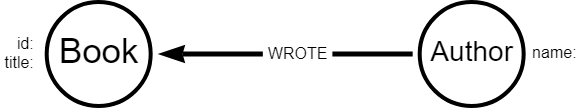

The data is relatively simple, and a single Cypher query could import it into the graph:

In [ ]:
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/books.csv'
AS row
MERGE (b:Book {id: row.id})
SET b.title = row.title
MERGE (a:Author {name: row.author})
MERGE (a)-[:WROTE]->(b)

Review the query and identify where it creates the Book and Author nodes and WROTE relationship.

However, if this was a more complicated data set with significantly more rows, you may experience issues with the import as it creates related data in a single pass.

Queries with multiple operations chained together have the potential to write data and then read data that is out of sync - which can result in an **Eager operator.**

The Eager operator will cause any operations to execute in their entirety before continuing, ensuring isolation between the different parts of the query. **When importing data the Eager operator can cause high memory usage and performance issues.**

A mechanism for **avoiding the Eager operator** is to **break the import into smaller parts.** By taking multiple passes over the data file, the query also becomes simpler to understand and change to fit the data model.

###In this example, the import could be broken into three parts:

1. Create Book nodes

2. Create Author nodes

3. Create WROTE relationships




In [ ]:
// Create `Book` nodes
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/books.csv'
AS row
MERGE (b:Book {id: row.id})
SET b.title = row.title;

// Create `Author` nodes
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/books.csv'
AS row
MERGE (a:Author {name: row.author});

// Create `WROTE` relationships
LOAD CSV WITH HEADERS
FROM 'https://data.neo4j.com/importing-cypher/books.csv'
AS row
MATCH (a:Author{name: row.author})
MATCH (b:Book{id: row.id})
MERGE (a)-[:WROTE]->(b);

###The Eager operator
Which of the following is a mechanism for avoiding the Eager operation when importing data?

** Break the import into smaller parts**

##**Other Import Options**
LOAD CSV is a convenient tool for importing data into Neo4j; there are however some considerations:

1. You may need to write Cypher statements to transform the data into the desired format. Depending on the data complexity, this can be time-consuming.

2. LOAD CSV may not be suitable for large data sets. The definition of large data sets depends on multiple factors, including the data structure, the use case, and the environment. A guideline of over 10 million rows is a good indicator for considering other import options.

3. You may need to import data from multiple sources, and LOAD CSV may not be the best option for all of them.

Complex business rules may require integration to other systems or data sources.

##**Neo4j Data Importer**
The **Neo4j Data Importer is a UI-based data importing tool.** The data importer is ideal to get started quickly with **testing and prototyping.** However, there are limited options for data transformation, and it is **unsuitable for large data sets.**

##**neo4j-admin**
The neo4j-admin import command line interface supports **importing large data sets.** neo4j-admin import **converts CSV files into the internal binary format** of Neo4j and can **import millions of rows within minutes.**

You need to **structure the import files in a specific way, and the database needs to be offline when the import is run.**

##**ETL (Extract, Transform, Load) Tool**
An ETL tool, for example Apache Hop, is a good choice for **importing data from multiple sources.** ETL tools generally support various data sources, can **transform data into the desired format, and have visualization tools.**